In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

In [ ]:
os.makedirs('kaggle/input/flicker8k')
os.makedirs('kaggle/working')
BASE_DIR='/content/kaggle/input/flicker8k'
WORKING_DIR='/content/kaggle/working'

In [ ]:
!unzip '/content/drive/MyDrive/ImageCaptioning/archive.zip' -d '/content/kaggle/input/flicker8k'

Streaming output truncated to the last 5000 lines.
  inflating: /content/kaggle/input/flicker8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/kaggle/input/flicker8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/kaggle/input/flicker8k/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/kaggle/input/flicker8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/kaggle/input/flicker8k/Images/2846037553_1a1de50709.jpg  
  inflating: /content/kaggle/input/flicker8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/kaggle/input/flicker8k/Images/2846843520_b0e6211478.jpg  
  inflating: /content/kaggle/input/flicker8k/Images/2847514745_9a35493023.jpg  
  inflating: /content/kaggle/input/flicker8k/Images/2847615962_c330bded6e.jpg  
  inflating: /content/kaggle/input/flicker8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/kaggle/input/flicker8k/Images/2848266893_9693c66275.jpg  
  inflating: /content/kaggle/input/flicker8k/Images/2848571082_26454c

## Load Images and Captions

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'),'r') as f:
  next(f) # as first line of captions.txt contains heading
  captions_doc = f.read()

In [ ]:
captions_doc

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
  # split the line by comma(,)
  tokens = line.split(',')
  if len(line) < 2:
    continue # just to tackle exception in case if there either 0 or just 1 word it's an error/unwanted caption

  image_id, caption = tokens[0],tokens[1:] # tokens[1:] is used instead of tokens[1] therefore caption will still be in a list of size 1

  # remove extension from image ID
  image_id = image_id.split('.')[0]

  # convert caption list to string
  caption = " ".join(caption) #  doing this will eliminate any possibility of having redundant spaces in tha caption

  # create list if needed
  if image_id not in mapping:
    mapping[image_id]=[]

  # store the caption
  mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
mapping["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
len(mapping)

8091

## Preprocess Images

In [ ]:
import numpy as np
import tensorflow as tf

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

from tqdm import tqdm

image_dir = os.path.join(BASE_DIR,"Images")
training_image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Get unique images
encode_train = sorted(set(training_image_paths))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  # print(batch_features)
  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 506/506 [02:21<00:00,  3.56it/s]


## Prepare Captions

In [ ]:
image_names = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

In [ ]:
training_image_names = [f[:-4] for f in image_names if not f.endswith('.npy')]

In [ ]:
# training_image_names

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import re

#--------------------------------------------------
# Cleaning the captions data using modular functions
#    Convert all words to lowercase.
#    Remove all punctuation.
#    Remove all words that are one character or less in length (e.g. ‘a’).
#    Remove all words with numbers in them.
#--------------------------------------------------
def captions_clean (image_dict):
  # <key> is the image_name, which can be ignored
  for key, captions in image_dict.items():

    # Loop through each caption for this image
    for i, caption in enumerate (captions):

      # Convert the caption to lowercase, and then remove all special characters from it
      caption_nopunct = re.sub(r"[^a-zA-Z0-9]+", ' ', caption.lower())

      # Split the caption into separate words, and collect all words which are more than
      # one character and which contain only alphabets (ie. discard words with mixed alpha-numerics)
      clean_words = [word for word in caption_nopunct.split() if ((len(word) > 1) and (word.isalpha()))]

      # Join those words into a string
      caption_new = ' '.join(clean_words)

      # Replace the old caption in the captions list with this new cleaned caption
      captions[i] = caption_new

#--------------------------------------------------
# Add two tokens, 'startseq' and 'endseq' at the beginning and end respectively,
# of every caption
#--------------------------------------------------
def add_token (captions):
  for i, caption in enumerate (captions):
    captions[i] = 'startseq ' + caption + ' endseq'
  return (captions)

#--------------------------------------------------
# Given a set of training, validation or testing image names, return a dictionary
# containing the corresponding subset from the full dictionary of images with captions
#
# This returned subset has the same structure as the full dictionary
# {"image_name_1" : ["caption 1", "caption 2", "caption 3"],
#  "image_name_2" : ["caption 4", "caption 5"]}
#--------------------------------------------------
def subset_data_dict (image_dict, image_names):
  dict = { image_name:add_token(captions) for image_name,captions in image_dict.items() if image_name in image_names}
  return (dict)

#--------------------------------------------------
# Flat list of all captions
#--------------------------------------------------
def all_captions (data_dict):
  return ([caption for key, captions in data_dict.items() for caption in captions])

#--------------------------------------------------
# Calculate the word-length of the caption with the most words
#--------------------------------------------------
def max_caption_length(captions):
  return max(len(caption.split()) for caption in captions)

#--------------------------------------------------
# Fit a Keras tokenizer given caption descriptions
# The tokenizer uses the captions to learn a mapping from words to numeric word indices
#
# Later, this tokenizer will be used to encode the captions as numbers
#--------------------------------------------------
def create_tokenizer(data_dict):
  captions = all_captions(data_dict)
  max_caption_words = max_caption_length(captions)

  # Initialise a Keras Tokenizer
  tokenizer = Tokenizer()

  # Fit it on the captions so that it prepares a vocabulary of all words
  tokenizer.fit_on_texts(captions)

  # Get the size of the vocabulary
  vocab_size = len(tokenizer.word_index) + 1

  return (tokenizer, vocab_size, max_caption_words)

#--------------------------------------------------
# Extend a list of text indices to a given fixed length
#--------------------------------------------------
def pad_text (text, max_length):
  text = pad_sequences([text], maxlen=max_length, padding='post')[0]

  return (text)

In [ ]:
captions_clean(mapping)
training_dict = subset_data_dict(mapping, training_image_names)


In [ ]:
# Prepare tokenizer
tokenizer, vocab_size, max_caption_words = create_tokenizer(training_dict)

In [ ]:
print(image_dir)
print(training_dict)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from array import array
def data_prep(data_dict, tokenizer, max_length, vocab_size):
  X, y = list(), list()

  # For each image and list of captions
  for image_name, captions in data_dict.items():
    image_name = image_name + '.jpg'
    image_name = os.path.join(image_dir,image_name)

    # For each caption in the list of captions
    for caption in captions:

      # Convert the caption words into a list of word indices
      word_idxs = tokenizer.texts_to_sequences([caption])[0]

      # Pad the input text to the same fixed length
      pad_idxs = pad_text(word_idxs, max_length)

      X.append(image_name)
      y.append(pad_idxs)

  # return array(X), array(y)
  return X, y

train_X, train_y = data_prep(training_dict, tokenizer, max_caption_words, vocab_size)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# Load the numpy files
def map_func(img_name, cap):
   img_tensor = np.load(img_name.decode('utf-8')+'.npy')
   return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# for item in dataset:
#   print(dataset)

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since we have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
embedding_dim = 256
units = 512
vocab_size = vocab_size
num_steps = len(train_X) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
import time
start_epoch = 0
EPOCHS = 50

# Define the ModelCheckpoint callback
# checkpoint_path = "/content/drive/MyDrive/ImageCaptioning/attention/checkpoints/model_{epoch:02d}_{loss:.4f}.h5"
# checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

    # Save model weights at the end of each epoch
    # checkpoint_callback.on_epoch_end(epoch, logs={'loss': total_loss / num_steps})

Epoch 1 Batch 0 Loss 2.4975
Epoch 1 Batch 100 Loss 1.5439
Epoch 1 Batch 200 Loss 1.4695
Epoch 1 Batch 300 Loss 1.3235
Epoch 1 Batch 400 Loss 1.1467
Epoch 1 Batch 500 Loss 1.1904
Epoch 1 Batch 600 Loss 1.2211
Epoch 1 Loss 1.357552
Time taken for 1 epoch 165.03 sec

Epoch 2 Batch 0 Loss 1.1686
Epoch 2 Batch 100 Loss 1.0477
Epoch 2 Batch 200 Loss 1.0358
Epoch 2 Batch 300 Loss 1.2528
Epoch 2 Batch 400 Loss 0.9862
Epoch 2 Batch 500 Loss 1.0980
Epoch 2 Batch 600 Loss 1.0833
Epoch 2 Loss 1.062440
Time taken for 1 epoch 82.37 sec

Epoch 3 Batch 0 Loss 1.0633
Epoch 3 Batch 100 Loss 0.9814
Epoch 3 Batch 200 Loss 0.9237
Epoch 3 Batch 300 Loss 1.0340
Epoch 3 Batch 400 Loss 1.0440
Epoch 3 Batch 500 Loss 0.9567
Epoch 3 Batch 600 Loss 0.8763
Epoch 3 Loss 0.958342
Time taken for 1 epoch 83.77 sec

Epoch 4 Batch 0 Loss 0.9221
Epoch 4 Batch 100 Loss 0.9062
Epoch 4 Batch 200 Loss 0.8127
Epoch 4 Batch 300 Loss 0.9192
Epoch 4 Batch 400 Loss 0.9204
Epoch 4 Batch 500 Loss 0.9757
Epoch 4 Batch 600 Loss 0.8121

1089181217_ee1167f7af


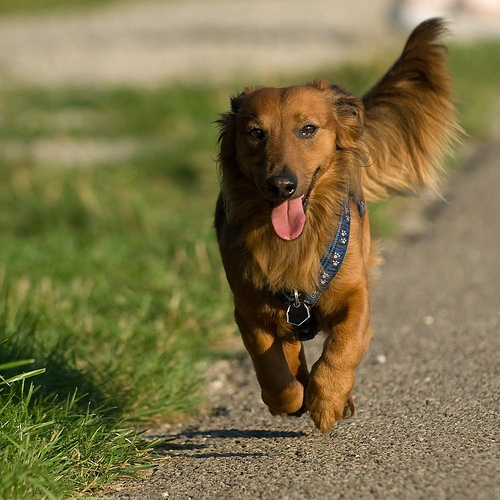

Real Captions: 
brown dog running down paved pathway
brown dog running next to grass
dog is running down road
light brown dog runs down path happily
energetic brown dog running

Prediction Caption: light brown dog runs down paved pathway
1095980313_3c94799968


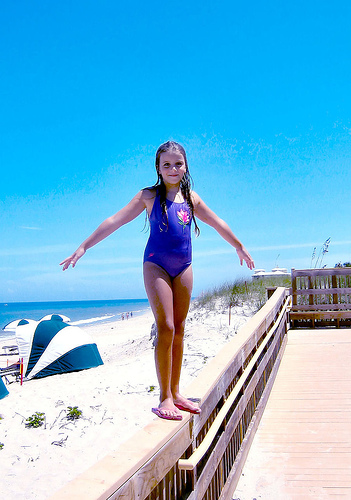

Real Captions: 
little girl in blue swimsuit is walking along wooden fence next to sandy beach
little girl with arms outstretched is posing at the beach
young girl walks on railing in front of the beach
little girl in blue swimsuit standing on handrail near beach
the little girl in the blue bathing suit is posing at the beach

Prediction Caption: little girl with arms outstretched is posing at the beach
466176275_f40d37851e


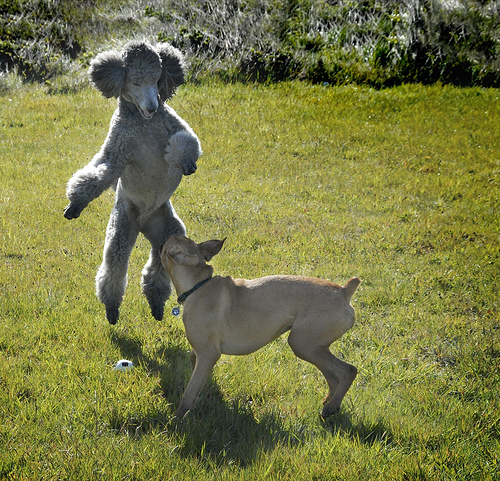

Real Captions: 
grey labradoodle jumps over another large dog
one grey puddle jumping in the air in front of another tan dog
two dogs are chasing each other in yard
two dogs playing in grass
two dogs the gray poodle high in the air play on the grass

Prediction Caption: two dogs are chasing each other in yard
3590654365_fd4819f48b


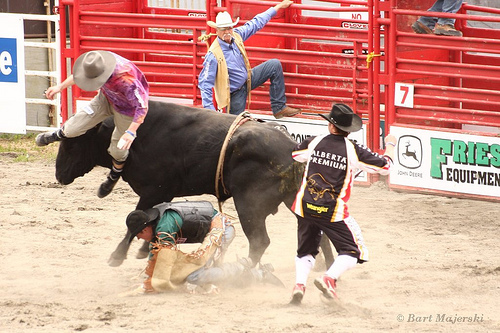

Real Captions: 
bull is tossing rider off him while several other cowboys try to restrain it
man is being thrown off bull during rodeo
four men in rodeo with bull bucking
man in purple shirt falls off bulls head
three people wrestle with bull at rodeo

Prediction Caption: three people wrestle with bull bucking
3601508034_5a3bfc905e


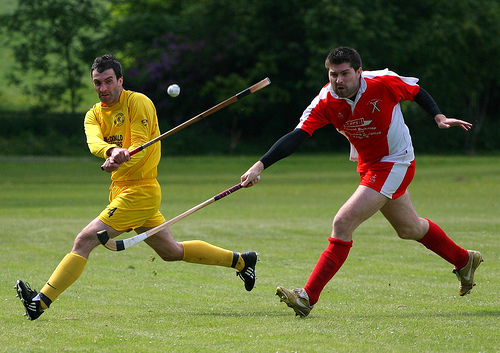

Real Captions: 
man dressed in yellow sports uniform and another man dressed in red and white sports uniform holding sticks with ball floating between them
the hockey player in yellow is challenging the player in red for the ball
two field hockey players attempt to hit ball with their sticks
two men in different colored jerseys play hockey
two men playing field hockey

Prediction Caption: two men chase ball chasing ball
3656104088_a0d1642fa9


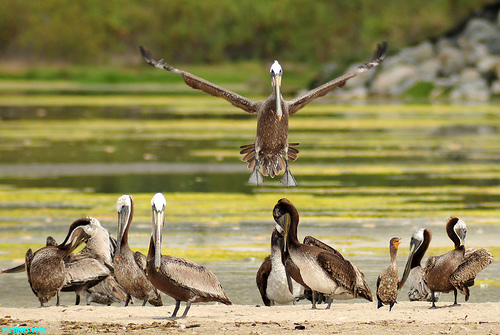

Real Captions: 
pelican in mid flight above group of pelicans
birds flocking by the water edge
large birds standing on the edge of body of water while one in the middle is coming down for landing
one bird is landing on the shore near many other birds
there are several pelicans and one is flying

Prediction Caption: large birds hugging


In [ ]:
def evaluate(image, max_length):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['startseq']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == 'endseq':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

def check_test(test_image_names, image_dict, image_dir, max_caption_words):
    # captions on the validation set
    rid = np.random.randint(0, len(test_image_names))
    image_name = test_image_names[rid]
    actual, predicted = list(), list()
    for image_name in test_image_names:
      print(image_name)
      real_captions = image_dict[image_name]
      # print(real_caption)

      image_name = image_name + '.jpg'
      image_path = os.path.join(image_dir,image_name)
      # print(image_path)
      result, attention_plot = evaluate(image_path, max_caption_words)
      result = result[:-1]

      actual_captions=list()
      from IPython.display import Image, display
      display(Image(image_path))
      print("Real Captions: ")
      for caption in real_captions:
        caption = caption.split()
        caption = caption[1:-1]
        actual_captions.append(caption)
        print(' '.join(caption),end="\n")
      print()
      actual.append(actual_captions)
      predicted.append(result)
      print('Prediction Caption:', ' '.join(result))
    return actual,predicted

testing_imgs = ["1089181217_ee1167f7af","1095980313_3c94799968","466176275_f40d37851e","3590654365_fd4819f48b","3601508034_5a3bfc905e","3656104088_a0d1642fa9"]
actual,predicted = check_test(list(testing_imgs), mapping, image_dir, max_caption_words)

## Computing BLEU Score

In [1]:
from nltk.translate.bleu_score import corpus_bleu
import random
# Filter names ending with '.jpg'
jpg_images = [name for name in image_names if name.lower().endswith('.jpg')]

# Calculate 20% of the total images
num_images_to_select = int(0.1 * len(jpg_images))

# Randomly select 20% of images
random_selected_images = random.sample(jpg_images, num_images_to_select)

# Remove '.jpg' extension and store in a separate list
random_selected_images_for_testing = [name[:-4] for name in random_selected_images]

actual,predicted = check_test(list(random_selected_images_for_testing), mapping, image_dir, max_caption_words)
# calculate the BLEU score
print("BLEU-1: %f" % corpus_bleu(actual,predicted, weights=(1.0,0,0,0)))
print("BLEU-2: %f" % corpus_bleu(actual,predicted, weights=(0.5,0.5,0,0)))
print("BLEU-3: %f" % corpus_bleu(actual,predicted, weights=(0.33,0.33,0.33,0)))
print("BLEU-4: %f" % corpus_bleu(actual,predicted, weights=(0.25,0.25,0.25,0.25)))

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import random
# Filter names ending with '.jpg'
jpg_images = [name for name in image_names if name.lower().endswith('.jpg')]

# Calculate 20% of the total images
num_images_to_select = int(0.2 * len(jpg_images))

# Randomly select 20% of images
random_selected_images = random.sample(jpg_images, num_images_to_select)

# Remove '.jpg' extension and store in a separate list
random_selected_images_for_testing = [name[:-4] for name in random_selected_images]

actual,predicted = check_test(list(random_selected_images_for_testing), mapping, image_dir, max_caption_words)
print("BLEU-1: %f" % corpus_bleu(actual,predicted, weights=(1.0,0,0,0)))
print("BLEU-2: %f" % corpus_bleu(actual,predicted, weights=(0.5,0.5,0,0)))
print("BLEU-3: %f" % corpus_bleu(actual,predicted, weights=(0.33,0.33,0.33,0)))
print("BLEU-4: %f" % corpus_bleu(actual,predicted, weights=(0.25,0.25,0.25,0.25)))

BLEU-1: 0.646201
BLEU-2: 0.537954
BLEU-3: 0.455301
BLEU-4: 0.380474


In [ ]:
# Save the model in TensorFlow SavedModel format
encoder.save('/content/drive/MyDrive/ImageCaptioning/attention/encoder_saved_model')
decoder.save('/content/drive/MyDrive/ImageCaptioning/attention/decoder_saved_model')